In [1]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import re

In [2]:
def get_pr_scores(results_file):
    
    results_df = pd.read_csv(results_file, header=None)
    y_pred = results_df[0].values
    y_true = results_df[1].values
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    avg_score = average_precision_score(y_true, y_pred) 
    
    return avg_score, precision, recall, thresholds


def get_auprc(recall, precision):
    # x must be monotonically increasing or decreasing
    return auc(recall, precision)

In [3]:
# GLOBALS
PILOT=False
MODEL_NAME="adda"
TF="RXRA"

if PILOT:
    suffix = "_pilot"
else:
    suffix = ""

In [4]:
def get_auprc_multiprocess(i):
    source_file = f"../results/mm10_archive/{TF}/{MODEL_NAME}_src_epoch{i}.csv.gz"
    target_file = f"../results/mm10_archive/{TF}/{MODEL_NAME}_tgt_epoch{i}.csv.gz"
    
    source_metrics = get_pr_scores(source_file)
    target_metrics = get_pr_scores(target_file)
    
    src_auprc = get_auprc(source_metrics[2], source_metrics[1])
    tgt_auprc = get_auprc(target_metrics[2], target_metrics[1])
    
    return i,src_auprc,tgt_auprc  

# Analyzing log files

## ADDA

In [5]:
string = "DEBUG:root:Source Validation APS: 0.333136152601636, Target Validation APS: 0.18968891579734382 after 0 epochs."

In [6]:
def get_auprcs_adda(string):
    pattern = re.compile(".+Source Validation APS: ([\.\d]+).+Target Validation APS: ([\.\d]+).+([\d]+) epochs.$")
    m = re.match(pattern, string)
    if m:
        src_auprc = m.group(1)
        tgt_auprc = m.group(2)
        epoch_num = m.group(3)
        return epoch_num, src_auprc, tgt_auprc  
    return 

In [7]:
get_auprcs_adda(string)

('0', '0.333136152601636', '0.18968891579734382')

In [8]:
logfile = f"./log/{TF}_adda.log"
met_list = []

with open(logfile, "r") as f:
    for lines in f:
        info = get_auprcs_adda(lines)
        if info:
            met_list.append(tuple(map(float, info)))


In [9]:
met_list

[(0.0, 0.2112118428769049, 0.1745473957906786),
 (1.0, 0.1791781601522966, 0.15555242666885227),
 (2.0, 0.20920405375174783, 0.18551269116478983),
 (3.0, 0.20559817582253054, 0.19117242021436442),
 (4.0, 0.20550993080240612, 0.1895218639713812),
 (5.0, 0.2057616751278691, 0.20232295656889251),
 (6.0, 0.20309807804016214, 0.19610913727627519),
 (7.0, 0.1959296488492169, 0.19225092385368664),
 (8.0, 0.18143861750427634, 0.18673728733787756),
 (9.0, 0.18163317159958714, 0.1807826353885628)]

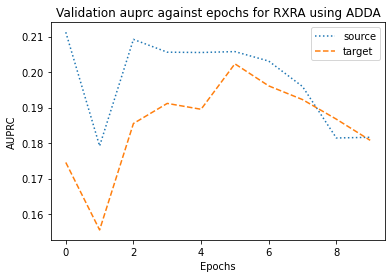

In [10]:
epochs = list(map(int, [m[0] for m in met_list]))
src_auprcs = [m[1] for m in met_list]
tgt_auprcs = [m[2] for m in met_list]

plt.plot(epochs, src_auprcs, label="source", linestyle="dotted")
plt.plot(epochs, tgt_auprcs, label="target", linestyle="dashed")
plt.legend();
plt.xlabel("Epochs")
plt.ylabel("AUPRC")
plt.title(f"Validation auprc against epochs for {TF} using ADDA");